# QSAR_Aquatic_Toxicity

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import scipy
import seaborn as sns
import math
import pickle


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (confusion_matrix,plot_confusion_matrix,
                            ConfusionMatrixDisplay,accuracy_score,f1_score,
                            mean_squared_error, mean_absolute_error, max_error,
                            r2_score, explained_variance_score)

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
from sklearn.neural_network import MLPRegressor

## Loading Data

In [55]:
Dataset = pd.read_csv('Regression_Datasets/3_Qsar_Aquatic_Toxicity/Qsar_Aquatic_Toxicity.csv', delimiter=';') 
Dataset.head()

,0,0.1,0.2,2.419,1.225,0.667,0.3,0.4,3.740
0,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
1,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
2,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
3,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
4,215.34,327.629,3,0.189,4.677,1.333,0,4,6.064


## Data Prepration And Analysis

In [86]:
print(np.count_nonzero(Dataset==np.nan))
print(np.count_nonzero(Dataset=="?"))
Dataset.isnull().sum()

0
0


0        0
0.1      0
0.2      0
2.419    0
1.225    0
0.667    0
0.3      0
0.4      0
3.740    0
dtype: int64

In [57]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       545 non-null    float64
 1   0.1     545 non-null    float64
 2   0.2     545 non-null    int64  
 3   2.419   545 non-null    float64
 4   1.225   545 non-null    float64
 5   0.667   545 non-null    float64
 6   0.3     545 non-null    int64  
 7   0.4     545 non-null    int64  
 8   3.740   545 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 38.4 KB


In [58]:
Dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
0,545.0,48.561872,46.760699,0.000,15.790,40.460,70.140,347.320
0.1,545.0,58.977035,68.182392,0.000,11.000,42.683,77.727,571.952
0.2,545.0,0.939450,1.619619,0.000,0.000,0.000,1.000,18.000
2.419,545.0,2.313299,1.743392,-6.446,1.228,2.273,3.395,9.148
1.225,545.0,2.494624,0.809925,1.000,1.975,2.344,2.913,6.439
0.667,545.0,1.046960,0.403720,0.281,0.737,1.021,1.267,2.500
0.3,545.0,1.005505,1.397860,0.000,0.000,1.000,2.000,11.000
0.4,545.0,0.354128,0.807426,0.000,0.000,0.000,0.000,11.000
3.740,545.0,4.660106,1.666279,0.122,3.601,4.530,5.610,10.047


In [59]:
Dataset.apply(lambda x: len(x.unique()))

0        227
0.1      210
0.2       11
2.419    405
1.225    342
0.667    403
0.3        9
0.4        6
3.740    514
dtype: int64

<AxesSubplot:>

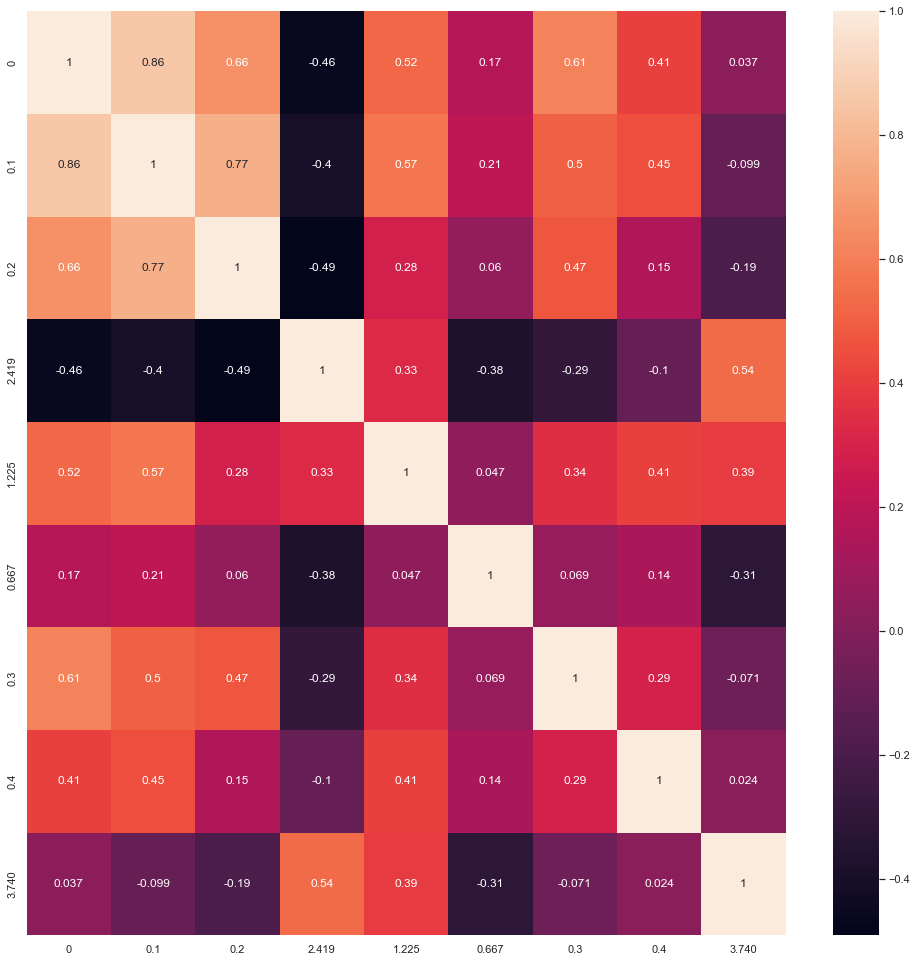

In [64]:
plt.figure(figsize=(17,17))
sns.heatmap(Dataset.corr(), annot =True )

<AxesSubplot:>

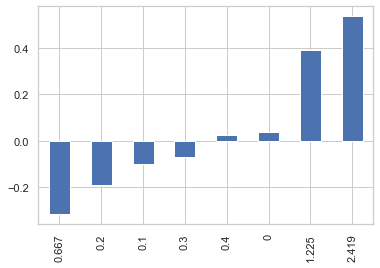

In [61]:
cor = Dataset.corr()['3.740'][:-1].sort_values()
cor.plot(kind="bar")

3.850    3
4.330    2
5.548    2
2.958    2
6.360    2
        ..
5.132    1
3.680    1
4.011    1
3.480    1
2.480    1
Name: 3.740, Length: 514, dtype: int64
---------------------------


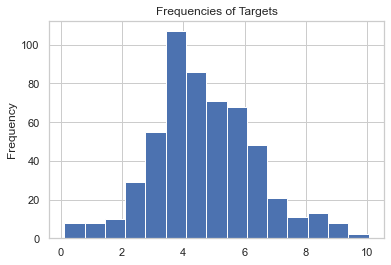

In [70]:
frequency = Dataset['3.740'].value_counts()
print(frequency)
print("---------------------------")
plt.title('Frequencies of Targets')
Dataset['3.740'].plot.hist(subplots=True, figsize=(20, 30), bins=15);

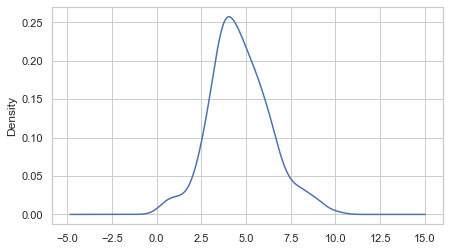

In [81]:
Dataset['3.740'].plot.kde(subplots=True, figsize=(7, 4));

### Defining Dictionary Of Models

In [59]:
# MODELS = {'linear_r', 'svr', 'decision_tree_r', 'random_forest_r', 'knn_r', 'adaboost_r', 'gaussian_process_r', 'neural_network_r'}
MODELS = {'linear_r', 'svr', 'decision_tree_r', 'random_forest_r','knn_r', "adaboost", "GaussianProcessRegressor", "nn_r"}
qsar_aquatic_toxicity_dict = {}  

## Train and Test set

In [60]:
x = Dataset.iloc[:,:-1]
y = Dataset.iloc[:, -1:]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.85, test_size=0.15, random_state=0)

y_train = y_train.to_numpy().reshape(-1)
y_test = y_test.to_numpy().reshape(-1)

In [8]:
StScale = StandardScaler()
StScale.fit(X_train)
X_train = StScale.transform(X_train)

X_test = StScale.transform(X_test)

In [46]:
from tabulate import tabulate
def model_results(model):
    table = [["Parameters / Metrics", "Tuned"]]
    curr_model = model['model']
    
    if model['hyperparameters'] == 1:
        for param in curr_model.best_params_:
            table.append([param, curr_model.best_params_[param]])
    
    linear_r_predict = curr_model.predict(X_test)
    
    rmse = np.sqrt( mean_squared_error(y_test, linear_r_predict))
    model['rmse'] = rmse
    mse = mean_squared_error(y_test, linear_r_predict)
    model['mse'] = mse
    r2 = r2_score(y_test, linear_r_predict)
    model['r2'] = r2
    
    linear_r_predict_trn = curr_model.predict(X_train)
    mse_trn = mean_squared_error(y_train, linear_r_predict_trn)
    model['mse_trn'] = mse_trn
    r2_trn = r2_score(y_train, linear_r_predict_trn)
    model['r2_trn'] = r2_trn
    
    table.append(['Root Mean Squarred Error', rmse])
    table.append(['Mean Squarred Error', mse])
    table.append(['r2 Score ',r2])
    table.append(['Mean Squarred Error (train)', mse_trn])
    table.append(['r2 Score (train)',r2_trn])
    
    print(tabulate(table, headers='firstrow', tablefmt='grid'))

## Linear Regression

In [10]:
linear_r = LinearRegression()
linear_r.fit(X_train, y_train)

qsar_aquatic_toxicity_dict['linear_r'] = {'model':linear_r, 'hyperparameters':0}

## Linear Regression Analysis

In [47]:
model_results(qsar_aquatic_toxicity_dict['linear_r'])

+-----------------------------+----------+
| Parameters / Metrics        |    Tuned |
+=============================+==========+
| Root Mean Squarred Error    | 1.01901  |
+-----------------------------+----------+
| Mean Squarred Error         | 1.03838  |
+-----------------------------+----------+
| r2 Score                    | 0.574774 |
+-----------------------------+----------+
| Mean Squarred Error (train) | 1.5001   |
+-----------------------------+----------+
| r2 Score (train)            | 0.469464 |
+-----------------------------+----------+


## Support Vector Regression

In [12]:
svr = SVR().fit(X_train,y_train)

In [13]:
parameters = {
    'C': scipy.stats.uniform(1, 10), 
    'gamma': scipy.stats.uniform(0.01, 10)
}
svr_model = RandomizedSearchCV(svr, parameters, verbose=1, n_iter=100, random_state=0).fit(X_train, y_train)
svr_model.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'C': 9.289400292173632, 'gamma': 0.05695476192547066}

In [14]:
svr_model.best_estimator_

SVR(C=9.289400292173632, gamma=0.05695476192547066)

## Support Vector Regression Analysis

In [48]:
qsar_aquatic_toxicity_dict['svr'] = {'model':svr_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['svr'])

+-----------------------------+-----------+
| Parameters / Metrics        |     Tuned |
+=============================+===========+
| C                           | 9.2894    |
+-----------------------------+-----------+
| gamma                       | 0.0569548 |
+-----------------------------+-----------+
| Root Mean Squarred Error    | 0.903438  |
+-----------------------------+-----------+
| Mean Squarred Error         | 0.8162    |
+-----------------------------+-----------+
| r2 Score                    | 0.665757  |
+-----------------------------+-----------+
| Mean Squarred Error (train) | 0.968502  |
+-----------------------------+-----------+
| r2 Score (train)            | 0.657472  |
+-----------------------------+-----------+


## Decision Tree Regression

In [16]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [17]:
parameters = {
    'max_depth': scipy.stats.uniform(1, 100),
    'min_samples_split': scipy.stats.uniform(0, 1) 
}
tree_model = RandomizedSearchCV(tree, parameters, verbose=1, n_iter=50, random_state=0).fit(X_train, y_train)
tree_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'max_depth': 84.7944907498804, 'min_samples_split': 0.09609840789396307}

### Decision tree Analysis

In [49]:
qsar_aquatic_toxicity_dict['decision_tree_r'] = {'model':tree_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['decision_tree_r'])

+-----------------------------+------------+
| Parameters / Metrics        |      Tuned |
+=============================+============+
| max_depth                   | 84.7945    |
+-----------------------------+------------+
| min_samples_split           |  0.0960984 |
+-----------------------------+------------+
| Root Mean Squarred Error    |  1.30462   |
+-----------------------------+------------+
| Mean Squarred Error         |  1.70203   |
+-----------------------------+------------+
| r2 Score                    |  0.303     |
+-----------------------------+------------+
| Mean Squarred Error (train) |  1.06304   |
+-----------------------------+------------+
| r2 Score (train)            |  0.624037  |
+-----------------------------+------------+


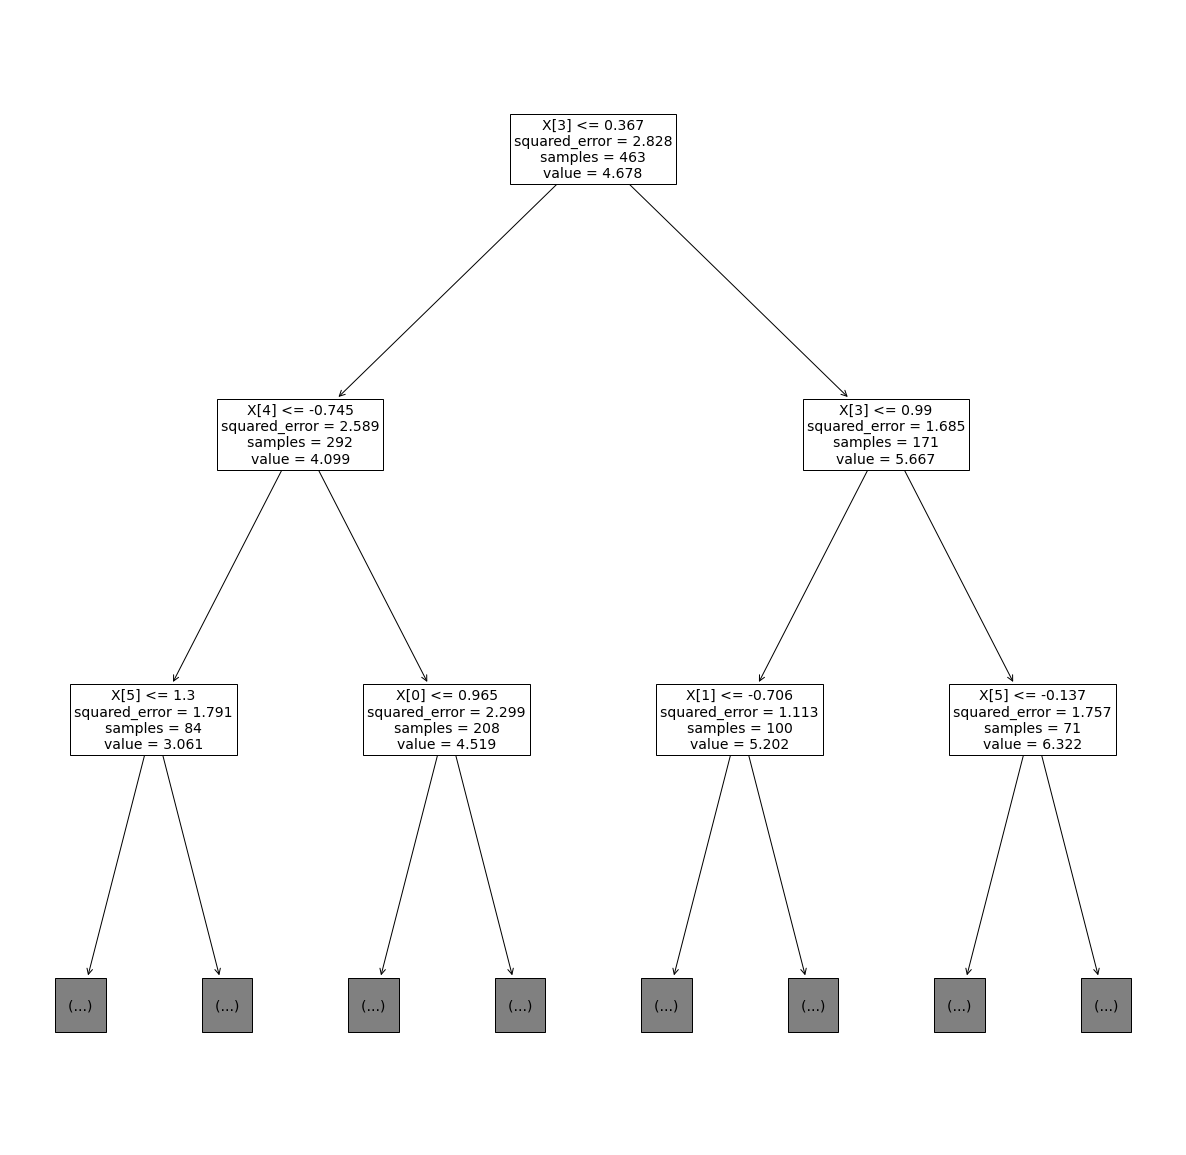

In [19]:
plt.figure(figsize=(21,21))
plot_tree(tree_model.best_estimator_, max_depth = 2, fontsize=14);

## Random Forest Regression

In [20]:
forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)

In [21]:
parameters = {
    'n_estimators': range(10,150),
    'max_depth': scipy.stats.uniform(1, 100),
}
forest_model = RandomizedSearchCV(forest, parameters, verbose=1, n_iter=20, random_state=0).fit(X_train, y_train)
forest_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'max_depth': 76.86156243223571, 'n_estimators': 124}

### Random Forest Analysis

In [50]:
qsar_aquatic_toxicity_dict['random_forest_r'] = {'model':forest_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['random_forest_r'])

+-----------------------------+-----------+
| Parameters / Metrics        |     Tuned |
+=============================+===========+
| max_depth                   | 46.615    |
+-----------------------------+-----------+
| n_estimators                | 44        |
+-----------------------------+-----------+
| Root Mean Squarred Error    |  1.00135  |
+-----------------------------+-----------+
| Mean Squarred Error         |  1.00271  |
+-----------------------------+-----------+
| r2 Score                    |  0.58938  |
+-----------------------------+-----------+
| Mean Squarred Error (train) |  0.206493 |
+-----------------------------+-----------+
| r2 Score (train)            |  0.92697  |
+-----------------------------+-----------+


## K Nearest Neighbours Regression

In [23]:
knn =  KNeighborsRegressor()

In [24]:
parameters = {
    'n_neighbors': range(1, 100), 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'weights': ['uniform', 'distance'], 
    'leaf_size': scipy.stats.uniform(1, 50)
}
knn_model = RandomizedSearchCV(knn, parameters,verbose=1,random_state=0,n_iter=100, cv =10).fit(X_train, y_train)
knn_model.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'algorithm': 'ball_tree',
 'leaf_size': 31.60478613612107,
 'n_neighbors': 18,
 'weights': 'distance'}

### KNN Analysis

In [51]:
qsar_aquatic_toxicity_dict['knn_r'] = {'model':knn_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['knn_r'])

+-----------------------------+-----------------------+
| Parameters / Metrics        | Tuned                 |
+=============================+=======================+
| algorithm                   | ball_tree             |
+-----------------------------+-----------------------+
| leaf_size                   | 31.60478613612107     |
+-----------------------------+-----------------------+
| n_neighbors                 | 18                    |
+-----------------------------+-----------------------+
| weights                     | distance              |
+-----------------------------+-----------------------+
| Root Mean Squarred Error    | 0.9893585361343625    |
+-----------------------------+-----------------------+
| Mean Squarred Error         | 0.9788303130219287    |
+-----------------------------+-----------------------+
| r2 Score                    | 0.599158212342402     |
+-----------------------------+-----------------------+
| Mean Squarred Error (train) | 0.00310941936645

## Adaboost

In [26]:
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(X_train,y_train)

In [28]:
param_distribution = {'learning_rate':scipy.stats.uniform(0.01,5),
                'n_estimators': range(1,250),
                'loss' : ['linear', 'square', 'exponential']}

In [29]:
adaBoost_model = RandomizedSearchCV(AdaBoost,
                                         param_distribution ,
                                         verbose=1, random_state=0,
                                         cv=5, n_iter=100).fit(X_train,y_train)


adaBoost_model.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'learning_rate': 1.1637116770339784, 'loss': 'square', 'n_estimators': 86}

### Adaboost Analysis

In [52]:
qsar_aquatic_toxicity_dict['adaboost'] = {'model':adaBoost_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['adaboost'])

+-----------------------------+---------------------+
| Parameters / Metrics        | Tuned               |
+=============================+=====================+
| learning_rate               | 0.10993832704379368 |
+-----------------------------+---------------------+
| loss                        | exponential         |
+-----------------------------+---------------------+
| n_estimators                | 115                 |
+-----------------------------+---------------------+
| Root Mean Squarred Error    | 1.1058466188144813  |
+-----------------------------+---------------------+
| Mean Squarred Error         | 1.2228967443434209  |
+-----------------------------+---------------------+
| r2 Score                    | 0.49921032215489647 |
+-----------------------------+---------------------+
| Mean Squarred Error (train) | 1.1322498865538366  |
+-----------------------------+---------------------+
| r2 Score (train)            | 0.5995592213651747  |
+---------------------------

## GaussianProcessRegressor

In [41]:
GPR = GaussianProcessRegressor(kernel = 1.0 * RBF(1.0), normalize_y = False)

In [42]:
param_distribution = {"alpha":scipy.stats.reciprocal(1e-11, 1e-8),
                      'kernel':[Matern(i) for i in [0, 0.2, 0.5, 1,2,3,5]]  +
                      [RBF(i) for i in [0, 0.2, 0.5, 1,2,3,5]]+[DotProduct(i) for i in [0, 0.2, 0.5, 1,2,3,5]] +[WhiteKernel(i) for i in [0.2, 0.5, 1,2,3,5]] }


In [43]:
GPR_model = RandomizedSearchCV(GPR, param_distribution, cv=5, n_iter=20 ,random_state=0,verbose=1)
GPR_model.fit(X_train, y_train)
GPR_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: 

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound 

{'alpha': 4.07414465416623e-09, 'kernel': DotProduct(sigma_0=2)}

### GaussianProcessRegressor analysis

In [53]:
qsar_aquatic_toxicity_dict['GaussianProcessRegressor'] = {'model':GPR_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['GaussianProcessRegressor'])

+-----------------------------+-----------------------+
| Parameters / Metrics        | Tuned                 |
+=============================+=======================+
| alpha                       | 4.07414465416623e-09  |
+-----------------------------+-----------------------+
| kernel                      | DotProduct(sigma_0=2) |
+-----------------------------+-----------------------+
| Root Mean Squarred Error    | 1.0190099881342531    |
+-----------------------------+-----------------------+
| Mean Squarred Error         | 1.038381355917371     |
+-----------------------------+-----------------------+
| r2 Score                    | 0.5747714047685865    |
+-----------------------------+-----------------------+
| Mean Squarred Error (train) | 1.5000950771430084    |
+-----------------------------+-----------------------+
| r2 Score (train)            | 0.46946407515594624   |
+-----------------------------+-----------------------+


## neural_network_regression (MLPRegressor)

In [35]:
nn_r = MLPRegressor()

In [36]:
param_distribution ={'max_iter': range(1000, 1500),
                     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                     'learning_rate':['constant', 'invscaling', 'adaptive'],
                     'alpha': scipy.stats.reciprocal(0.00001, 0.1), 
                    'solver':["adam",'sgd'],
                    'activation':["identity",'tanh', "relu", "logistic"]   
}

In [37]:
nnr_model = RandomizedSearchCV(nn_r,
                                         param_distribution ,
                                         verbose=1, random_state=0,
                                         cv=5, n_iter=100).fit(X_train,y_train)


nnr_model.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1211) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1211) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1211) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1088) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1069) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1069) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1069) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1377) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1228) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1228) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1327) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1327) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1286) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1340) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1340) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1340) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1022) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1022) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1022) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1022) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1370) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1357) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1357) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1357) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1168) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1168) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1168) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1168) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1343) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1208) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1208) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1245) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

{'activation': 'relu',
 'alpha': 0.0008140675984583287,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 1337,
 'solver': 'sgd'}

### neural_network_regression analysis

In [54]:
qsar_aquatic_toxicity_dict['nn_r'] = {'model':nnr_model, 'hyperparameters':1}
model_results(qsar_aquatic_toxicity_dict['nn_r'])

+-----------------------------+-----------------------+
| Parameters / Metrics        | Tuned                 |
+=============================+=======================+
| activation                  | tanh                  |
+-----------------------------+-----------------------+
| alpha                       | 2.518696096303566e-05 |
+-----------------------------+-----------------------+
| hidden_layer_sizes          | (50, 100, 50)         |
+-----------------------------+-----------------------+
| learning_rate               | adaptive              |
+-----------------------------+-----------------------+
| max_iter                    | 1038                  |
+-----------------------------+-----------------------+
| solver                      | sgd                   |
+-----------------------------+-----------------------+
| Root Mean Squarred Error    | 0.9606663804062866    |
+-----------------------------+-----------------------+
| Mean Squarred Error         | 0.92287989444291

----------------------------------------



### Analyzing Models for QSAR_Aquatic_Toxicity

+--------------------------+---------+------------+---------------+--------------------+----------+
| Model Name               |     MSE |   r2 Score |   MSE (train) |   r2 Score (train) |     RMSE |
+==========================+=========+============+===============+====================+==========+
| decision_tree_r          | 1.70203 |   0.303    |    1.06304    |           0.624037 | 1.30462  |
+--------------------------+---------+------------+---------------+--------------------+----------+
| random_forest_r          | 1.00271 |   0.58938  |    0.206493   |           0.92697  | 1.00135  |
+--------------------------+---------+------------+---------------+--------------------+----------+
| GaussianProcessRegressor | 1.03838 |   0.574771 |    1.5001     |           0.469464 | 1.01901  |
+--------------------------+---------+------------+---------------+--------------------+----------+
| adaboost                 | 1.2229  |   0.49921  |    1.13225    |           0.599559 | 1.10585  |


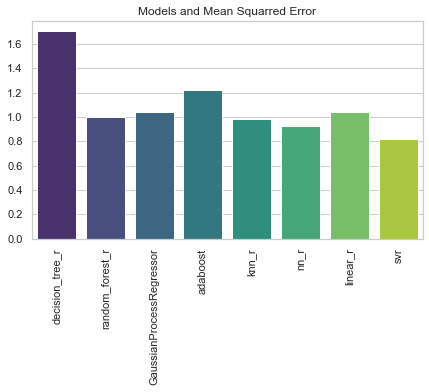

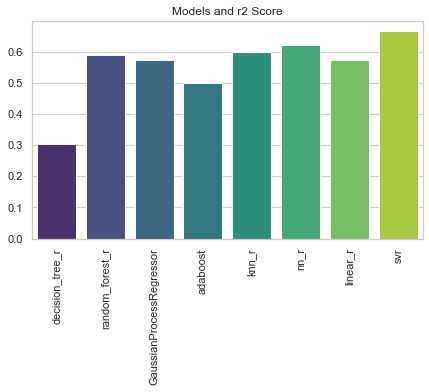

In [62]:
def cross_checking_model_results(dictionary):
    table = [["Model Name", "MSE", "r2 Score","MSE (train)", "r2 Score (train)" , "RMSE"]]
    x_models = []
    y_mse = []
    y_r2 = []
    y_mse_trn = []
    y_r2_trn = []
    y_rmse = []
    
    for model_key in MODELS:
        table.append([model_key, dictionary[model_key]['mse'], dictionary[model_key]['r2'],
                                 dictionary[model_key]['mse_trn'], dictionary[model_key]['r2_trn'],
                                                         dictionary[model_key]['rmse']            ])
        x_models.append(model_key)
        y_mse.append(dictionary[model_key]['mse'])
        y_r2.append(dictionary[model_key]['r2'])
        y_mse_trn.append(dictionary[model_key]['mse_trn'])
        y_r2_trn.append(dictionary[model_key]['r2_trn'])
        y_rmse.append(dictionary[model_key]['rmse'])
    print(tabulate(table, headers='firstrow', tablefmt='grid'))
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(7,4))
    ax1 = sns.barplot(x=x_models, y=y_mse, palette="viridis")
    ax1.set_title('Models and Mean Squarred Error')
    ax1.set_xticklabels(labels=x_models, rotation=90)
    plt.figure(figsize=(7,4))
    ax2 = sns.barplot(x=x_models, y=y_r2, palette="viridis")
    ax2.set_title('Models and r2 Score')
    ax2.set_xticklabels(labels=x_models, rotation=90)


cross_checking_model_results(qsar_aquatic_toxicity_dict)

### Regression Dictionary
Exporting Model Data for Later Analysis and Comparison

In [48]:
with open('base_regression_dict.dictionary', 'rb') as config_dictionary_file:
    base_regression_dict = pickle.load(config_dictionary_file)

base_regression_dict['qsar_aquatic_toxicity']= qsar_aquatic_toxicity_dict

with open('base_regression_dict.dictionary', 'wb') as config_dictionary_file:
    pickle.dump(base_regression_dict, config_dictionary_file)